In [23]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [24]:
data_dir = Path.cwd().parents[1] / "_data"

assert data_dir.exists(), data_dir
list(data_dir.glob("*.csv"))

[PosixPath('/Users/jd/Desktop/repos/ama_ws25/_data/siebenkampf.csv'),
 PosixPath('/Users/jd/Desktop/repos/ama_ws25/_data/life_expectancy_data.csv')]

In [25]:
df = (
    pd.read_csv(data_dir / "life_expectancy_data.csv")
    .pipe(
        lambda d: d.set_axis(
            d.columns.str.strip().str.lower()
            .str.replace(" ", "_")
            .str.replace("__+", "_", regex=True),
            axis=1,
        )
    )
    .assign(
        year=lambda d: pd.to_datetime(d.year.astype(str), format="%Y", errors="coerce"),
    )
    .pipe(
        lambda d: d.assign(
            **{
                col: pd.to_numeric(d[col], errors="coerce")
                for col in d.columns
                if col not in {"country", "status", "year"}
            }
        )
    )
)
df.head()

,country,year,status,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,...,polio,total_expenditure,diphtheria,hiv/aids,gdp,population,thinness_1-19_years,thinness_5-9_years,income_composition_of_resources,schooling
0,Afghanistan,2015-01-01,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014-01-01,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013-01-01,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012-01-01,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011-01-01,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


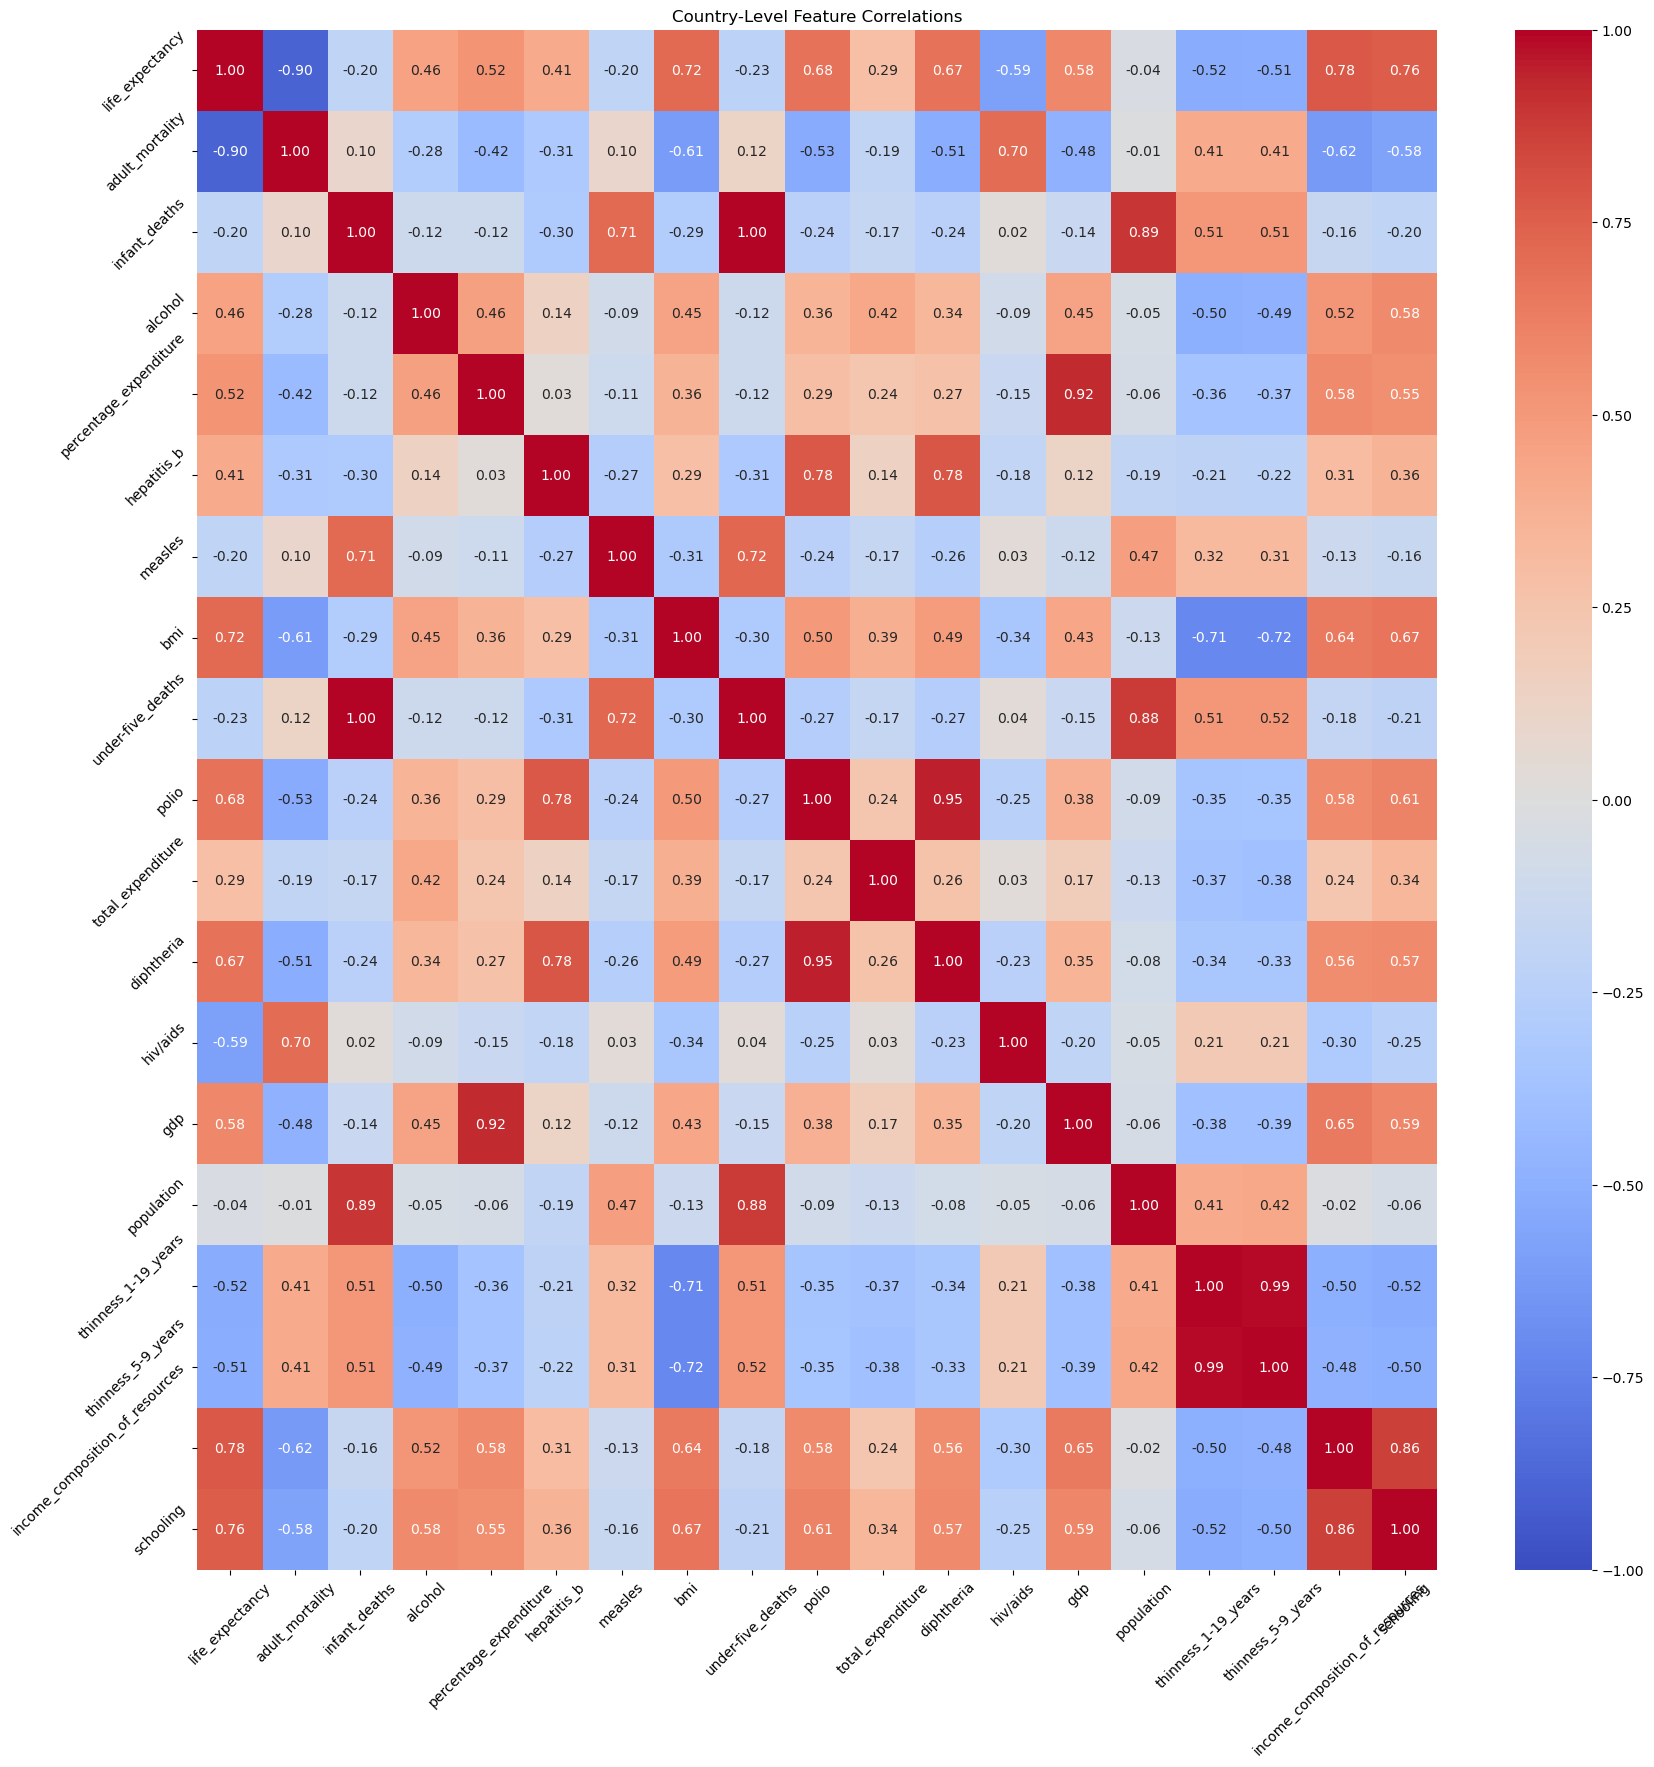

,country,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,bmi,under-five_deaths,polio,total_expenditure,diphtheria,hiv/aids,gdp,population,thinness_1-19_years,thinness_5-9_years,income_composition_of_resources,schooling
0,Afghanistan,58.19375,269.0625,78.2500,0.014375,34.960110,64.562500,2362.2500,15.51875,107.5625,48.3750,8.252500,52.3125,0.10000,340.015425,9.972260e+06,16.58125,15.58125,0.415375,8.21250
1,Albania,75.15625,45.0625,0.6875,4.848750,193.259091,98.000000,53.3750,49.06875,0.9375,98.1250,5.945625,98.0625,0.10000,2119.726679,6.969116e+05,1.61875,1.70000,0.709875,12.13750
2,Algeria,73.61875,108.1875,20.3125,0.406667,236.185241,78.000000,1943.8750,48.74375,23.5000,91.7500,4.604000,91.8750,0.10000,2847.853392,2.164983e+07,6.09375,5.97500,0.694875,12.71250
3,Angola,49.01875,328.5625,83.7500,5.740667,102.100268,70.222222,3561.3125,18.01875,132.6250,46.1250,3.919333,47.6875,2.36875,1975.143045,1.014710e+07,6.19375,6.66875,0.458375,8.04375
4,Antigua and Barbuda,75.05625,127.5000,0.0000,7.949333,1001.585226,98.266667,0.0000,38.42500,0.0000,96.9375,4.791333,98.3125,0.12500,9759.305728,1.274585e+07,3.42500,3.37500,0.488625,8.84375


In [ ]:
df = (
    df
    .dropna(subset=["life_expectancy"])
    .groupby("country", as_index=False)
    .mean(numeric_only=True)
    .pipe(
        lambda d: d.assign(
            **{
                col: d[col].fillna(d[col].mean())
                for col in d.columns
                if col != "country"
            }
        )
    )
 )

plt.figure(figsize=(20, 20))
(
    df
    .drop(columns=["country"])
    .corr()
    .pipe(
        lambda d: sns.heatmap(
            d,
            annot=True,
            fmt=".2f",
            cmap="coolwarm",
            vmin=-1,
            vmax=1,
        )
    )
)
plt.tick_params(axis="both", rotation=45)
plt.title("Country-Level Feature Correlations")
plt.show()
df.head()

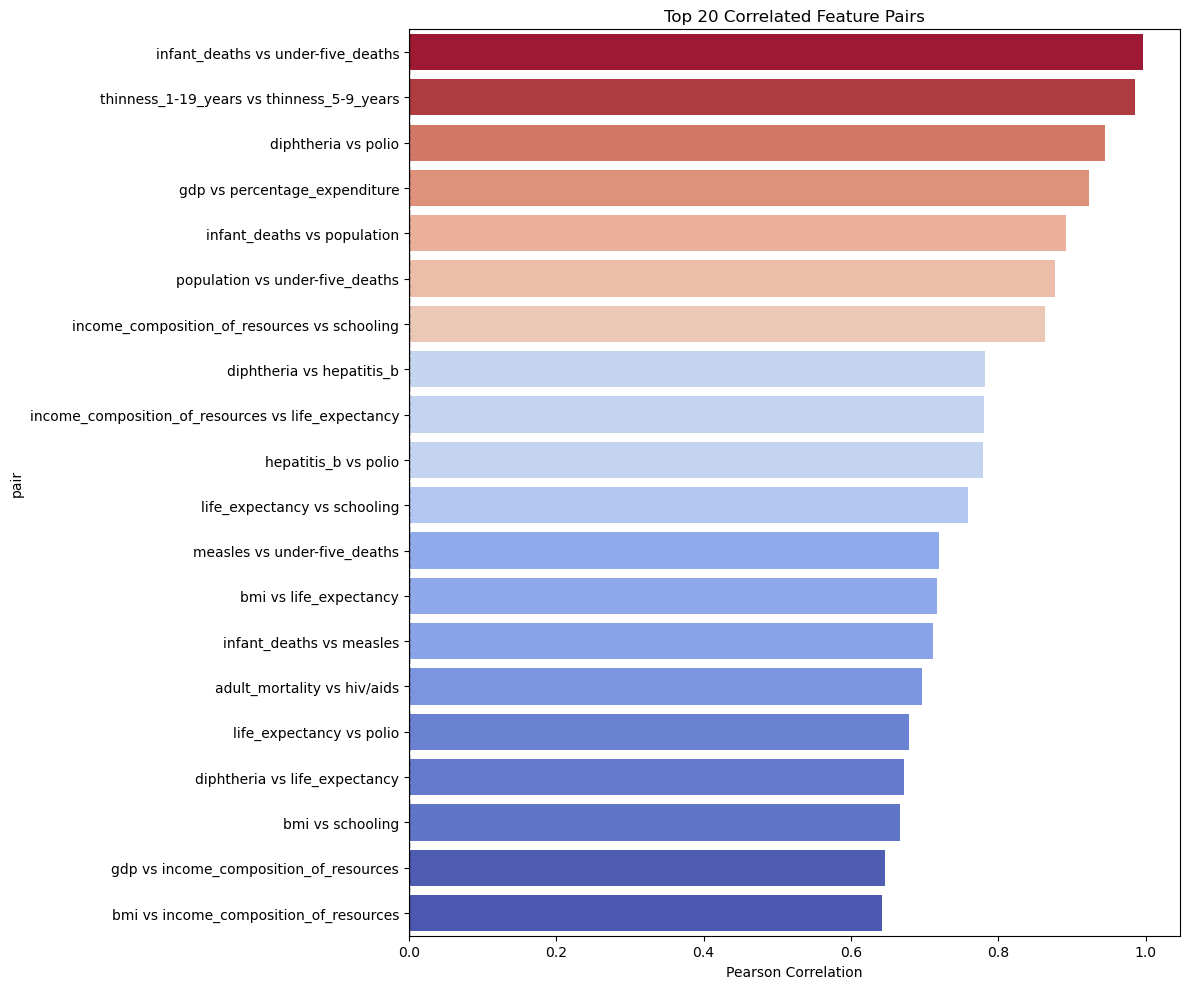

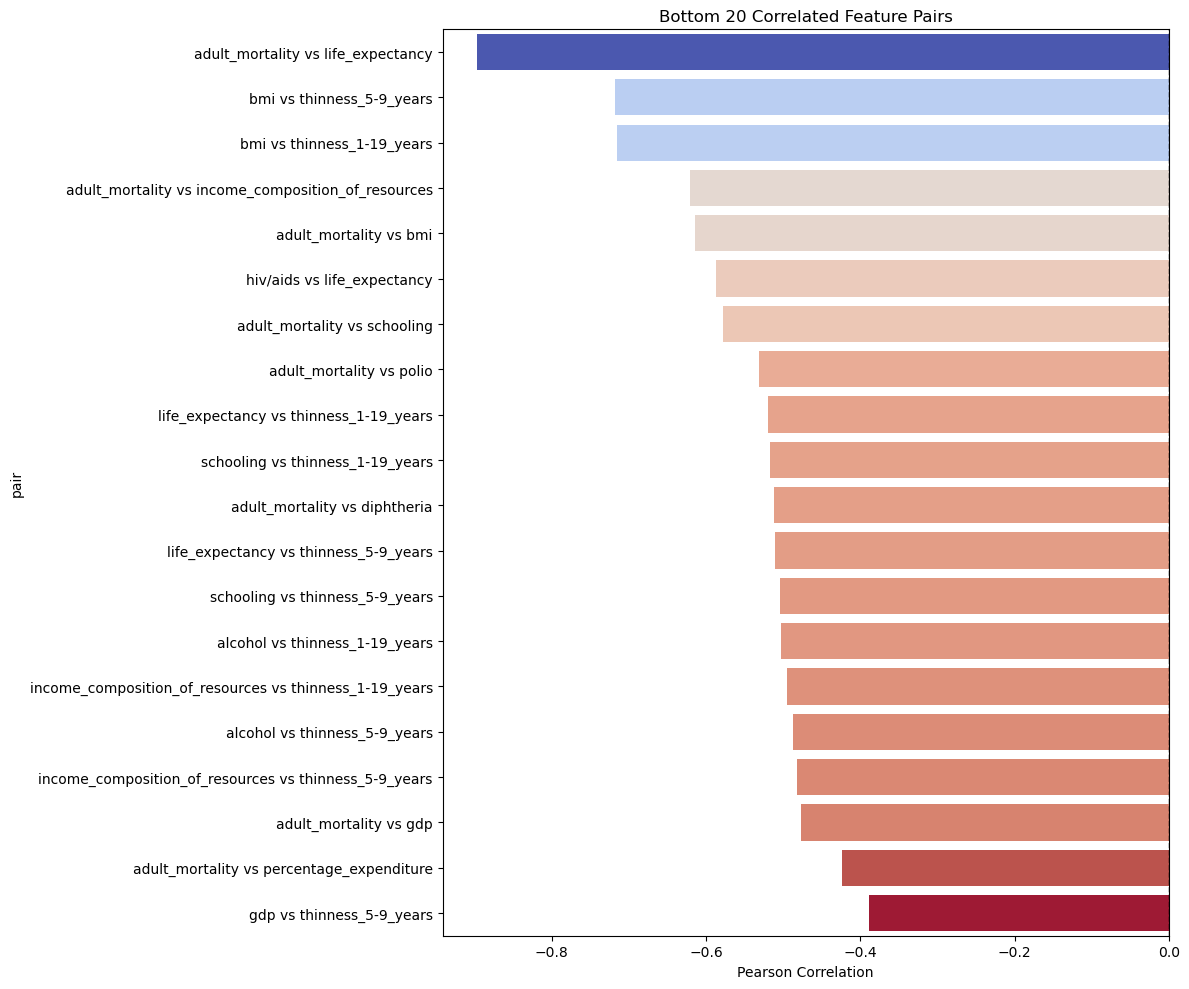

In [ ]:
corr_pairs = (
    df
    .drop(columns=["country"])
    .corr()
    .stack()
    .reset_index(name="correlation")
    .query("level_0 < level_1")
    .assign(
        pair=lambda d: d.level_0 + " vs " + d.level_1,
        corr=lambda d: d.correlation,
    )
    .sort_values("correlation", ascending=False)
    .assign(rank=lambda d: d.index + 1)
 )
corr_pairs.head(10)

plt.figure(figsize=(12, 10))
sns.barplot(
    data=corr_pairs.head(20),
    x="correlation",
    y="pair",
    hue="correlation",
    palette="coolwarm",
    legend=False,
 )
plt.title("Top 20 Correlated Feature Pairs")
plt.xlabel("Pearson Correlation")
plt.axvline(0, color="black", linewidth=1, linestyle="--")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 10))
sns.barplot(
    data=corr_pairs.tail(20).sort_values("correlation"),
    x="correlation",
    y="pair",
    hue="correlation",
    palette="coolwarm",
    legend=False,
 )
plt.title("Bottom 20 Correlated Feature Pairs")
plt.xlabel("Pearson Correlation")
plt.axvline(0, color="black", linewidth=1, linestyle="--")
plt.tight_layout()
plt.show()

/var/folders/tq/w_yq51q901g31lqy10hn7b000000gn/T/ipykernel_34721/583728035.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


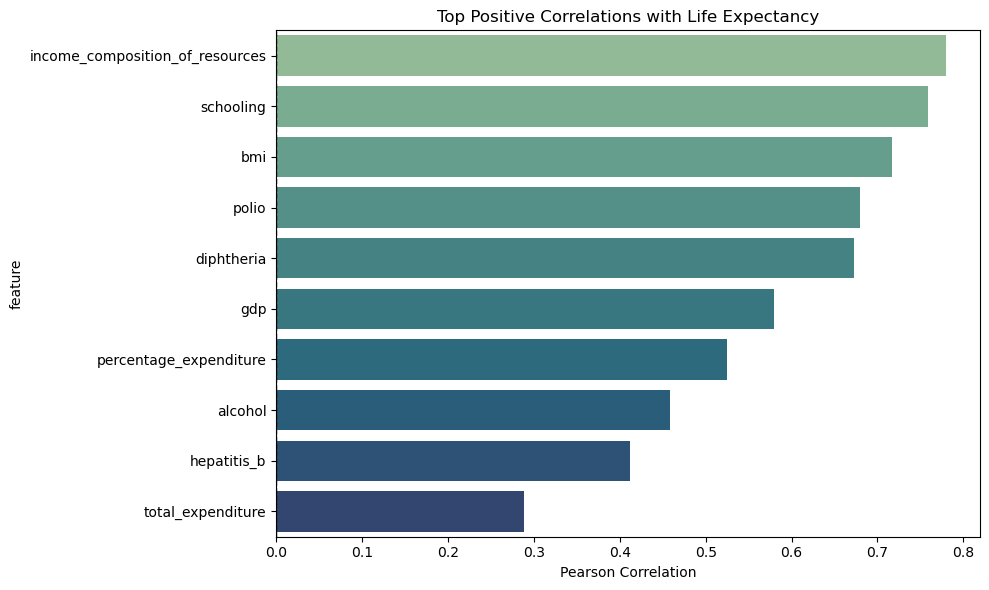

/var/folders/tq/w_yq51q901g31lqy10hn7b000000gn/T/ipykernel_34721/583728035.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


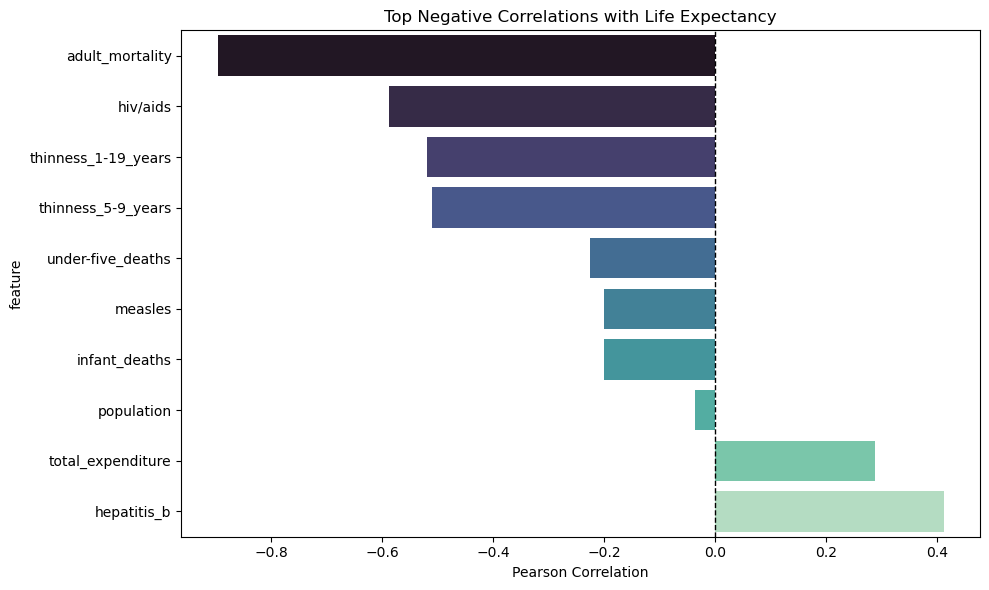

In [ ]:
life_corr = (
    df
    .drop(columns=["country"])
    .corr()
    .loc["life_expectancy"]
    .drop("life_expectancy")
    .sort_values(ascending=False)
    .to_frame(name="correlation")
    .assign(feature=lambda d: d.index)
    .reset_index(drop=True)
 )
life_corr.head(10)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=life_corr.head(10),
    x="correlation",
    y="feature",
    palette="crest",
)
plt.title("Top Positive Correlations with Life Expectancy")
plt.xlabel("Pearson Correlation")
plt.axvline(0, color="black", linewidth=1, linestyle="--")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(
    data=life_corr.tail(10).sort_values("correlation"),
    x="correlation",
    y="feature",
    palette="mako",
)
plt.title("Top Negative Correlations with Life Expectancy")
plt.xlabel("Pearson Correlation")
plt.axvline(0, color="black", linewidth=1, linestyle="--")
plt.tight_layout()
plt.show()

In [ ]:
df_std = (
    df
    .pipe(
        lambda d: pd.concat(
            [
                d[["country"]],
                pd.DataFrame(
                    StandardScaler().fit_transform(d.drop(columns=["country"])),
                    columns=d.drop(columns=["country"]).columns,
                    index=d.index,
                ),
            ],
            axis=1,
        )
    )
)
df.head()

,country,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,bmi,under-five_deaths,polio,total_expenditure,diphtheria,hiv/aids,gdp,population,thinness_1-19_years,thinness_5-9_years,income_composition_of_resources,schooling
0,Afghanistan,58.19375,269.0625,78.2500,0.014375,34.960110,64.562500,2362.2500,15.51875,107.5625,48.3750,8.252500,52.3125,0.10000,340.015425,9.972260e+06,16.58125,15.58125,0.415375,8.21250
1,Albania,75.15625,45.0625,0.6875,4.848750,193.259091,98.000000,53.3750,49.06875,0.9375,98.1250,5.945625,98.0625,0.10000,2119.726679,6.969116e+05,1.61875,1.70000,0.709875,12.13750
2,Algeria,73.61875,108.1875,20.3125,0.406667,236.185241,78.000000,1943.8750,48.74375,23.5000,91.7500,4.604000,91.8750,0.10000,2847.853392,2.164983e+07,6.09375,5.97500,0.694875,12.71250
3,Angola,49.01875,328.5625,83.7500,5.740667,102.100268,70.222222,3561.3125,18.01875,132.6250,46.1250,3.919333,47.6875,2.36875,1975.143045,1.014710e+07,6.19375,6.66875,0.458375,8.04375
4,Antigua and Barbuda,75.05625,127.5000,0.0000,7.949333,1001.585226,98.266667,0.0000,38.42500,0.0000,96.9375,4.791333,98.3125,0.12500,9759.305728,1.274585e+07,3.42500,3.37500,0.488625,8.84375


In [ ]:
pred_cols = df_std.columns.difference(["country", "life_expectancy"])

pca_model = PCA().fit(df_std[pred_cols])
pca_model

,n_components,None
,copy,True
,whiten,False
,svd_solver,'auto'
,tol,0.0
,iterated_power,'auto'
,n_oversamples,10
,power_iteration_normalizer,'auto'
,random_state,None
